In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets

from google.cloud import bigquery
%load_ext google.cloud.bigquery

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

sns.set(style='darkgrid', font_scale=1.5)
#sns.set_style('darkgrid', {"xtick.minor.size": 10, "ytick.major.size": 10})
current_palette = sns.color_palette('deep')

# Descriptive Statistics Table

In this table, we look at different statistics regarding the pseudo fixed effects used in our analysis. 

In [14]:
%%bigquery df_desc


WITH t1 AS(
SELECT 
    appln_id_US AS appln_id, attorney_id_US AS attorney_id, 
    examiner_id, examiner_art_unit, appln_filing_year_US AS filing_year
FROM `usptobias.usptobias_dataset.8_final_dataset_2002_2012`
), t2 AS(
SELECT 
    'Attorney' Name, 
    COUNT(CASE WHEN attorney_id IS NOT NULL THEN 1 END) Number, 
    COUNT(DISTINCT attorney_id) Unique,
    (SELECT MIN(f1) FROM(SELECT COUNT(appln_id) f1 FROM t1 WHERE attorney_id IS NOT NULL GROUP BY attorney_id)) Min,
    (SELECT AVG(f1) FROM(SELECT COUNT(appln_id) f1 FROM t1 WHERE attorney_id IS NOT NULL GROUP BY attorney_id)) Mean,
    (SELECT MAX(f1) FROM(SELECT COUNT(appln_id) f1 FROM t1 WHERE attorney_id IS NOT NULL GROUP BY attorney_id)) Max
FROM t1
), t3 AS(
SELECT 
    'Examiner' Name, 
    COUNT(CASE WHEN examiner_id IS NOT NULL THEN 1 END) Number, 
    COUNT(DISTINCT examiner_id) Unique,
    (SELECT MIN(f1) FROM(SELECT COUNT(appln_id) f1 FROM t1 WHERE examiner_id IS NOT NULL GROUP BY examiner_id)) Min,
    (SELECT AVG(f1) FROM(SELECT COUNT(appln_id) f1 FROM t1 WHERE examiner_id IS NOT NULL GROUP BY examiner_id)) Mean,
    (SELECT MAX(f1) FROM(SELECT COUNT(appln_id) f1 FROM t1 WHERE examiner_id IS NOT NULL GROUP BY examiner_id)) Max
FROM t1
), t4 AS(
SELECT 
    'Art Unit' Name, 
    COUNT(CASE WHEN examiner_art_unit IS NOT NULL THEN 1 END) Number, 
    COUNT(DISTINCT examiner_art_unit) Unique,
    (SELECT MIN(f1) FROM(SELECT COUNT(appln_id) f1 FROM t1 WHERE examiner_art_unit IS NOT NULL GROUP BY examiner_art_unit)) Min,
    (SELECT AVG(f1) FROM(SELECT COUNT(appln_id) f1 FROM t1 WHERE examiner_art_unit IS NOT NULL GROUP BY examiner_art_unit)) Mean,
    (SELECT MAX(f1) FROM(SELECT COUNT(appln_id) f1 FROM t1 WHERE examiner_art_unit IS NOT NULL GROUP BY examiner_art_unit)) Max
FROM t1
), t5 AS(
SELECT 
    'Filing Year' Name, 
    COUNT(CASE WHEN filing_year IS NOT NULL THEN 1 END) Number, 
    COUNT(DISTINCT filing_year) Unique,
    (SELECT CAST(MIN(f1) AS INT64) FROM(SELECT COUNT(appln_id) f1 FROM t1 WHERE filing_year IS NOT NULL GROUP BY filing_year)) Min,
    (SELECT AVG(f1) FROM(SELECT COUNT(appln_id) f1 FROM t1 WHERE filing_year IS NOT NULL GROUP BY filing_year)) Mean,
    (SELECT MAX(f1) FROM(SELECT COUNT(appln_id) f1 FROM t1 WHERE filing_year IS NOT NULL GROUP BY filing_year)) Max
FROM t1
)

SELECT * FROM t2 UNION ALL
SELECT * FROM t3 UNION ALL
SELECT * FROM t4 UNION ALL
SELECT * FROM t5

In [15]:
dic_names = {'Name': 'Name of Fixed Effect', 
             'Number': 'Total number of applications',
             'Unique': 'Number of unique observations', 
             'Min': 'Minimum number of applications', 
             'Mean': 'Average number of applications', 
             'Max': 'Maximum number of applications'}

df_desc.rename(columns=dic_names)

,Name of Fixed Effect,Total number of applications,Number of unique observations,Minimum number of applications,Average number of applications,Maximum number of applications
0,Filing Year,2097799,11,158560,190709.000000,222292
1,Art Unit,1868619,709,1,2635.569817,20172
2,Examiner,1868619,12306,1,151.846173,4476
3,Attorney,1868520,19310,1,96.764371,63147


In [627]:
df_desc.to_csv('../documentation/2_summ_statistic.csv')

# 1. Availability Of Different Attributed In Our Final Dataset

In this part, we will investigate the number of missing values for different variables that we have used in our analysis.

In [611]:
%%bigquery df_nulls

WITH t1 AS(
    SELECT *
    FROM `usptobias.usptobias_dataset.8_final_dataset_2002_2012`
)
SELECT 
    'Valid' AS type,
    COUNT(CASE WHEN granted_US IS NOT NULL THEN 1 END) AS nb_granted,
    COUNT(CASE WHEN twins_avg_grant IS NOT NULL THEN 1 END) AS nb_twins_avg,
    COUNT(CASE WHEN docdb_avg_grant IS NOT NULL THEN 1 END) AS nb_docdb_avg,
    COUNT(CASE WHEN appln_filing_year_US IS NOT NULL THEN 1 END) AS nb_filing_year,
    COUNT(CASE WHEN attorney_id_US IS NOT NULL THEN 1 END) AS nb_attorney,
    COUNT(CASE WHEN examiner_id IS NOT NULL THEN 1 END) AS nb_examiners,
    COUNT(CASE WHEN examiner_art_unit IS NOT NULL THEN 1 END) AS nb_artunit,
    COUNT(CASE WHEN small_entity IS NOT NULL THEN 1 END) AS nb_small_entity,
    COUNT(CASE WHEN nb_rejection IS NOT NULL THEN 1 END) AS nb_rejection,
    COUNT(CASE WHEN nb_transaction IS NOT NULL THEN 1 END) AS nb_transaction,
    COUNT(CASE WHEN same_country_origin IS NOT NULL THEN 1 END) AS nb_same_origin,
    
    COUNT(CASE WHEN invt_foreign IS NOT NULL THEN 1 END) AS nb_invt_foreign,
    COUNT(CASE WHEN attorney_FE IS NOT NULL THEN 1 END) AS nb_attorney_fe,
    COUNT(CASE WHEN examiner_FE IS NOT NULL THEN 1 END) AS nb_examiner_fe,
    COUNT(CASE WHEN artunit_FE IS NOT NULL THEN 1 END) AS nb_artunit_fe
    
FROM t1 UNION ALL
SELECT 
    'NA' AS type,
    COUNT(CASE WHEN granted_US IS NULL THEN 1 END) AS nb_granted,
    COUNT(CASE WHEN twins_avg_grant IS NULL THEN 1 END) AS nb_twins_avg,
    COUNT(CASE WHEN docdb_avg_grant IS NULL THEN 1 END) AS nb_docdb_avg,
    COUNT(CASE WHEN appln_filing_year_US IS NULL THEN 1 END) AS nb_filing_year,
    COUNT(CASE WHEN attorney_id_US IS NULL THEN 1 END) AS nb_attorney,
    COUNT(CASE WHEN examiner_id IS NULL THEN 1 END) AS nb_examiners,
    COUNT(CASE WHEN examiner_art_unit IS NULL THEN 1 END) AS nb_artunit,
    COUNT(CASE WHEN small_entity IS NULL THEN 1 END) AS nb_small_entity,
    COUNT(CASE WHEN nb_rejection IS NULL THEN 1 END) AS nb_rejection,
    COUNT(CASE WHEN nb_transaction IS NULL THEN 1 END) AS nb_transaction,
    COUNT(CASE WHEN same_country_origin IS NULL THEN 1 END) AS nb_same_origin,
    
    COUNT(CASE WHEN invt_foreign IS NULL THEN 1 END) AS nb_invt_foreign,
    COUNT(CASE WHEN attorney_FE IS NULL THEN 1 END) AS nb_attorney_fe,
    COUNT(CASE WHEN examiner_FE IS NULL THEN 1 END) AS nb_examiner_fe,
    COUNT(CASE WHEN artunit_fe IS NULL THEN 1 END) AS nb_artunit_fe
    
FROM t1

In [620]:
df_nulls[df_nulls.type=='NA']

,type,nb_granted,nb_twins_avg,nb_docdb_avg,nb_filing_year,nb_attorney,nb_examiners,nb_artunit,nb_small_entity,nb_rejection,nb_transaction,nb_same_origin,nb_invt_foreign,nb_attorney_fe,nb_examiner_fe,nb_artunit_fe
0,NA,0,0,295454,0,229279,229180,229180,229180,229180,229180,229183,229183,426059,421235,421029


In [613]:
df_plot = df_nulls.set_index('type').transpose()[['Valid', 'NA']]
df_plot.head(2)

type,Valid,NA
nb_granted,2097799,0
nb_twins_avg,2097799,0


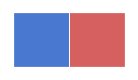

In [614]:
palette_list = [sns.color_palette('muted')[0], sns.color_palette('muted')[3]]
sns.palplot(palette_list)

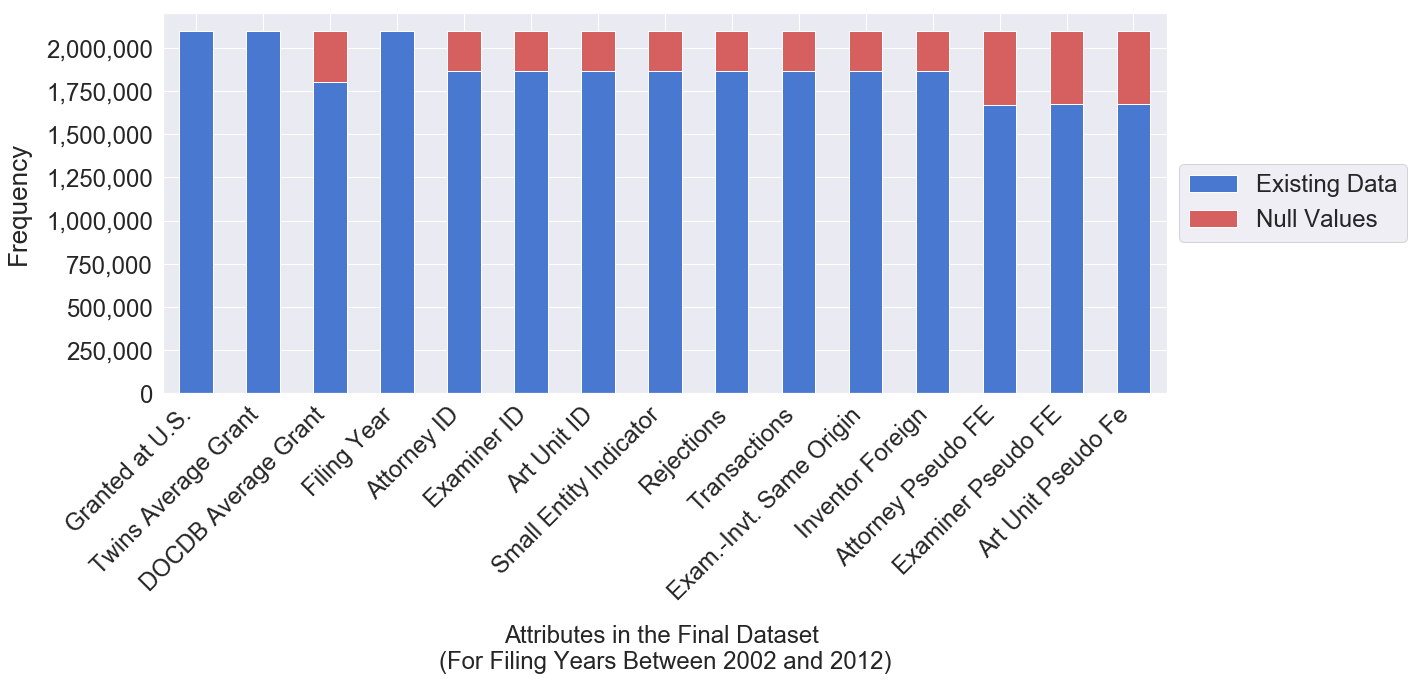

In [615]:
# Creating custom cmap

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(18,7))
df_plot.plot(ax=ax, kind='bar', stacked=True, color=palette_list)
ax.bar
ax.set_xlabel('Attributes in the Final Dataset \n(For Filing Years Between 2002 and 2012)', fontsize=24, labelpad=20)
ax.set_ylabel('Frequency', fontsize=26, labelpad=15)
#ax.tick_params(rotation=40)
xlabels = ['Granted at U.S.', 'Twins Average Grant', 'DOCDB Average Grant', 'Filing Year', 
           'Attorney ID', 'Examiner ID', 'Art Unit ID', 'Small Entity Indicator', 
           'Rejections', 'Transactions', 'Exam.-Invt. Same Origin', 'Inventor Foreign', 'Attorney Pseudo FE', 
           'Examiner Pseudo FE', 'Art Unit Pseudo Fe']
ax.set_xticklabels(xlabels, rotation = 60, ha="right", fontdict={'fontsize':24})

ax.legend(['Existing Data', 'Null Values'], fontsize=24, # you can send a list to change the legends
          loc='center left', bbox_to_anchor=(1., 0.5)) # bbox_to_anchor is for putting legend outside the plot

#ax.set_yscale('log')
#ax.set_xticks(ax.get_xticks()) # list of xticks positions
ax.set_xticklabels(ax.get_xticklabels(), fontdict={'fontsize':24}, rotation=45, ha='right')

ax.set_yticklabels(ax.get_yticklabels(), fontdict={'fontsize':24})
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

#ax.set_title('Average Grant Rate for Different Authority Offices', fontsize=20, pad=20)
plt.show()

# 1. Family ID

### What is the distribution of family IDs?

In [594]:
%%bigquery df_1
WITH a AS(
    SELECT
        family_id,
        COUNT(Distinct appln_id) AS nb_members
    FROM
        `usptobias.usptobias_dataset.4_family_custom_PCT`
    GROUP BY
        family_id
)

SELECT
    nb_members,
    COUNT(family_id) AS freq
FROM a
GROUP BY nb_members
ORDER BY nb_members

In [595]:
%%bigquery df_2
WITH a AS(
    SELECT
        docdb_family_id AS family_id,
        COUNT(appln_id) AS nb_members
    FROM
        `usptobias.patstat.tls201`
    GROUP BY
        docdb_family_id
)

SELECT
    nb_members,
    COUNT(family_id) AS freq
FROM a
GROUP BY nb_members
ORDER BY nb_members

In [602]:
df_1.head(2)

,nb_members,freq
0,1,66870444
1,2,2959464


In [603]:
df_2.head(2)

,nb_members,freq
0,1,62079193
1,2,2682781


In [601]:
df_2.nb_members.max()

472

In [527]:
df_1['Type'] = 'Custom Family'
df_2['Type'] = 'DOCDB Family'
df_2 = df_2[df_2.nb_members<=80]

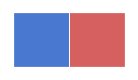

In [552]:
palette_list = [sns.color_palette('muted')[0], sns.color_palette('muted')[3]]
sns.palplot(palette_list)

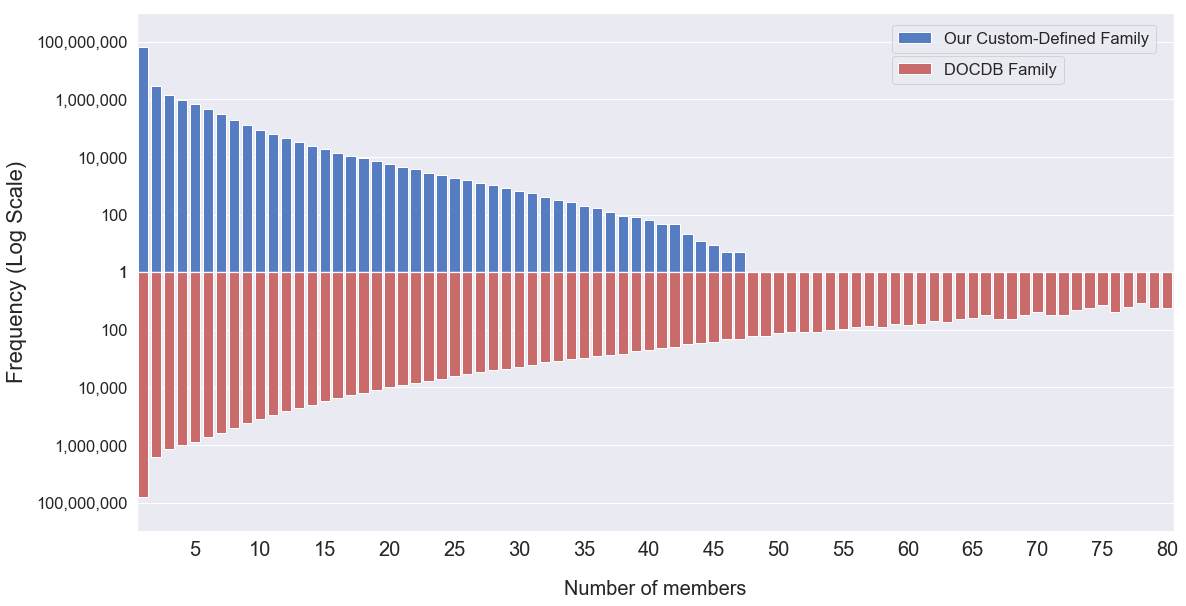

In [553]:
sns.set_color_codes("muted")

fig = plt.figure(figsize=(18,9))

ax = fig.add_axes([1.0, 0.5, 0.8, 0.4])
gax = sns.barplot(ax=ax, x="nb_members", y="freq",  data=df_1,
            saturation=.8, color='b', label='Our Custom-Defined Family')
gax.set_ylim([1, 1e9])

ax2 = fig.add_axes([1.0, 0.1, 0.8, 0.4], sharex=ax)
gax2 = sns.barplot(ax=ax2, x="nb_members", y="freq", data=df_2,
            saturation=.8, color='r', label='DOCDB Family')
gax2.set_ylim([1, 1e9])

# Formatting legends
ax.legend(loc='center left', bbox_to_anchor=(.72, 0.9))
ax2.legend(loc='center left', bbox_to_anchor=(0.72, 1.78))

# Formatting x-axis
ax.xaxis.set_tick_params(rotation=90)
ax2.xaxis.set_tick_params(rotation=90)
ax2.set_xlabel('Number of members', fontsize=20, labelpad=20)
ax.set_xticklabels([], fontdict={'fontsize':20}, rotation=0, ha='center')
ax2.set_xticklabels([x.get_text() if (i+1)%5==0 else '' for i, x in enumerate(ax2.get_xticklabels())],
                    fontdict={'fontsize':20}, rotation=0, ha='center')
# Formatting y-axis
ax.set_yscale('log')
ax2.set_yscale('log')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax2.invert_yaxis()
ax.set_ylabel('', fontsize=22)
ax2.set_ylabel('', fontsize=22)
fig.text(0.90, 0.5, 'Frequency (Log Scale)', va='center', rotation='vertical', fontsize=22)

#ax.set_title('Frequency Plot of Number of Members in Different Family Definitions', fontsize=23, pad=15)

plt.show()

# 2. Patent Authority Offices

## 2.1. Applications' Filing Year Distribution for Different Authorities

Here, we look at the number of applications that have been filed in different jurisdictions over the years 2002 to 2012.

In [374]:
%%bigquery df_

WITH t1 AS(
    SELECT
        a.appln_id,
        a.appln_auth,
        b.appln_filing_year AS filing_year
    FROM `usptobias.usptobias_dataset.4_family_custom_PCT` a
    INNER JOIN `usptobias.patstat.tls201` b USING(appln_id)
)

SELECT
    appln_auth,
    filing_year,
    COUNT(DISTINCT appln_id) AS frequency
FROM t1
WHERE filing_year BETWEEN 2002 AND 2012
GROUP BY appln_auth, filing_year
ORDER BY appln_auth

In [375]:
auth_list = ['US', 'EP', 'JP', 'CN', 'KR', 'DE', 'CA', 'AU', 'TW']

df_plot = df_.copy()
df_plot = df_plot[df_plot.appln_auth.isin(auth_list)]
df_plot['appln_auth'] = pd.Categorical(df_plot['appln_auth'],
                                       categories=auth_list, 
                                       ordered=True)
df_plot = df_plot.sort_values(['filing_year', 'appln_auth'])
df_plot.head(3)

,appln_auth,filing_year,frequency
1153,US,2002,344998
374,EP,2002,120367
610,JP,2002,430612


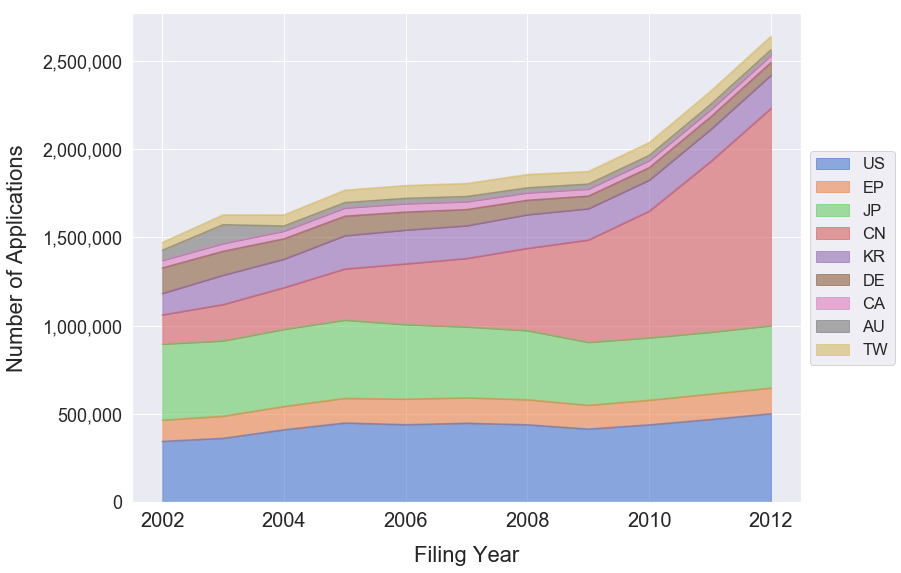

In [399]:
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12,9))
df_plot.pivot(values='frequency', columns='appln_auth', index='filing_year') \
       .plot(ax=ax, kind='area', stacked=True, color=sns.color_palette('muted'), alpha=0.6)
ax.bar

# Formatting x-axis
ax.set_xlabel('Filing Year', fontsize=22, labelpad=15)
#ax.set_xticklabels(ax.get_xticklabels(), fontdict={'fontsize':16}, rotation=45, ha='right') #or rotation='horizontal'
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 

# Formatting y-axis
ax.set_ylabel('Number of Applications', fontsize=22, labelpad=15)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
    
# Formatting plot
ax.legend(#['First', 'Second', 'Third'], # you can send a list to change the legends
          loc='center left', bbox_to_anchor=(1., 0.5)) # bbox_to_anchor is for putting legend outside the plot

#ax.set_title('Number of Applications Between 2002-2012 For Differen Authority Offices', fontsize=20, pad=15)

plt.show()

## 2.2. Relative Frequencies of Covered Applications by Exact Twins

Now, we want to know what portion of patents do we cover by using the definition of exact twins.

In [117]:
%%bigquery df_

WITH t1 AS(
    SELECT
        family_id,
        COUNT(DISTINCT CASE WHEN appln_auth='US' THEN appln_id END) AS nb_US,
        COUNT(DISTINCT appln_id) AS nb_total
    FROM
        `usptobias.usptobias_dataset.4_family_custom_PCT`
    GROUP BY
        family_id
), t2 AS(
    SELECT
        a.appln_id,
        a.family_id,
        a.appln_auth,
        (CASE WHEN (nb_total>1) THEN 1 ELSE 0 END) AS exist_twin
    FROM `usptobias.usptobias_dataset.4_family_custom_PCT` AS a
    LEFT JOIN t1 USING(family_id)
)

SELECT
    appln_auth,
    exist_twin,
    COUNT(*) AS frequency
FROM t2
GROUP BY appln_auth, exist_twin
ORDER BY appln_auth

In [123]:
df_ = df_.sort_values(by=['exist_twin'], ascending=True)
df_.head(2)

,appln_auth,exist_twin,frequency
246,PE,0,5354
75,CY,0,4320


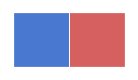

In [126]:
palette_list = [sns.color_palette('muted')[0], sns.color_palette('muted')[3]]
sns.palplot(palette_list)

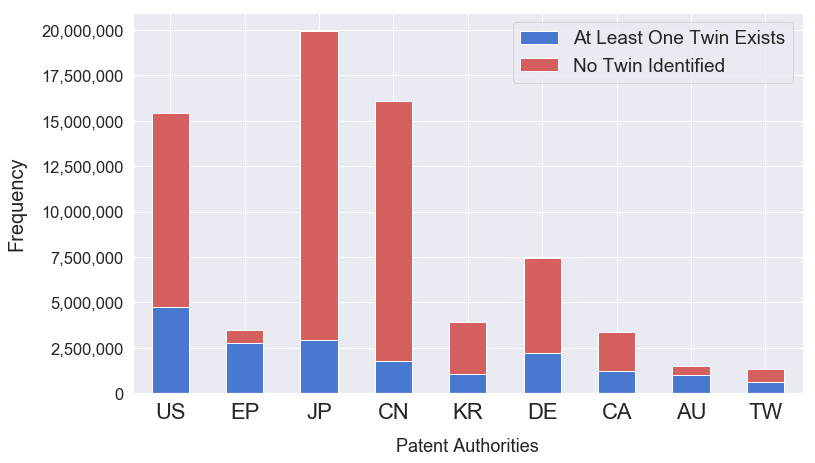

In [127]:
auth_list = ['US', 'EP', 'JP', 'CN', 'KR', 'DE', 'CA', 'AU', 'TW']

df_plot = df_[df_.appln_auth.isin(auth_list)]
df_plot.loc[:,'appln_auth'] = pd.Categorical(df_plot.loc[:,'appln_auth'], 
                                       categories=auth_list, 
                                       ordered=True)

df_plot = df_plot.sort_values(['appln_auth', 'exist_twin'])

# Changing the values in 'exact_twins' column
dict_map = {0:'No Twin Identified', 1:'At Least One Twin Exists'}
df_plot.loc[:,'exist_twin'] = df_plot.loc[:,'exist_twin'].map(dict_map)

fig, ax = plt.subplots(1, 1, figsize=(12,7))
df_plot.pivot(values='frequency', columns='exist_twin', index='appln_auth') \
       .reindex(index=auth_list) \
       .plot(ax=ax, kind='bar', stacked=True, color=palette_list)

ax.bar

# Formatting x-axis
ax.set_xlabel('Patent Authorities', fontsize=18, labelpad=15)
ax.set_xticklabels(ax.get_xticklabels(), fontdict={'fontsize':22}, rotation=0, ha='center')

# Formatting y-axis
ax.set_ylabel('Frequency', fontsize=20, labelpad=15)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xticklabels(ax.get_xticklabels(), fontdict={'fontsize':22}, rotation=0, ha='center')

# Formatting Plot
ax.legend(title='', fontsize=19)#['First', 'Second', 'Third'], # you can send a list to change the legends
#          loc='center left', bbox_to_anchor=(1., 0.5)) # bbox_to_anchor is for putting legend outside the plot
#ax.set_yscale('log')
#ax.set_xticks(ax.get_xticks()) # list of xticks positions

#ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    
#ax.set_title('My title', fontsize=20)
plt.show()

## 2.3. Grant Ratio For Different Authorities in Different Years

We now look into the average grant rate withing different jurisdictions over the years 2002 to 2012.

In [570]:
%%bigquery df_

WITH t1 AS(
    SELECT
        a.appln_id,
        a.appln_auth,
        b.appln_filing_year AS filing_year,
        CAST(CAST(b.granted AS INT64) AS FLOAT64) granted
    FROM `usptobias.usptobias_dataset.4_family_custom_PCT` a
    INNER JOIN `usptobias.patstat.tls201` b USING(appln_id)
    WHERE appln_filing_year BETWEEN 2002 AND 2012
)


SELECT
    appln_auth,
    filing_year,
    AVG(granted) AS avg_grant
FROM t1
GROUP BY appln_auth, filing_year


In [571]:
auth_list = ['US', 'EP', 'JP', 'CN', 'KR', 'DE', 'CA', 'AU', 'TW']

df_plot = df_.copy()
df_plot = df_plot[df_plot.appln_auth.isin(auth_list)]
df_plot['appln_auth'] = pd.Categorical(df_plot['appln_auth'],
                                       categories=auth_list, 
                                       ordered=True)
df_plot = df_plot.sort_values(['filing_year', 'appln_auth'])

df_plot.head(3)

,appln_auth,filing_year,avg_grant
8,US,2002,0.630891
705,EP,2002,0.504532
29,JP,2002,0.368220


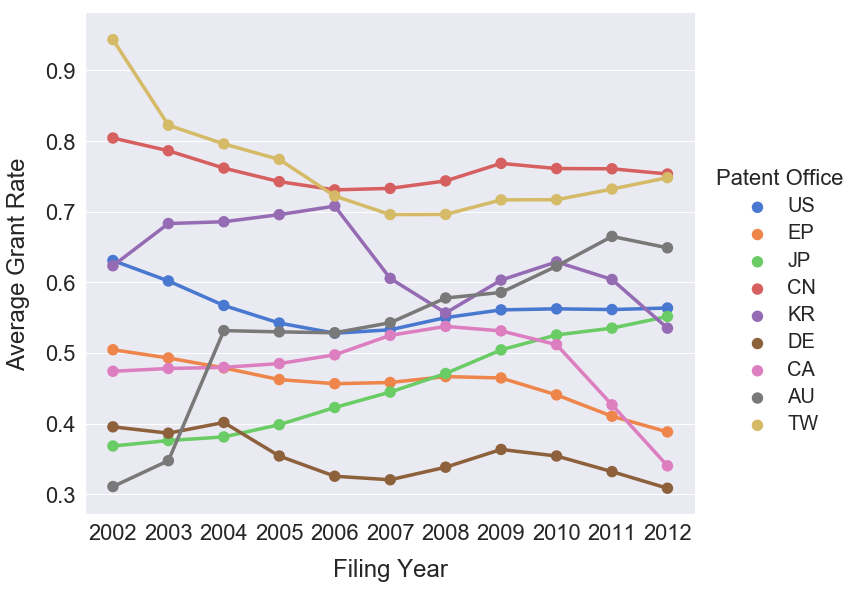

In [579]:
g = sns.catplot(x="filing_year", y="avg_grant", ci=95, hue='appln_auth', scale=1.3,
                data=df_plot, kind='point', height=8, aspect=1.2, palette='muted') #

# Formatting x-axis
g.set_xlabels('Filing Year', fontsize=24, labelpad=15)
#g.set_xticklabels(ax.get_xticklabels(), fontdict={'fontsize':19}, rotation=0, ha='center')

# Formatting y-axis
g.set_ylabels('Average Grant Rate', fontsize=24, labelpad=15)
#g.set_yticklabels(g.get_yticklabels(), fontdict={'fontsize':19}, rotation=0)
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
    ax.set_xticklabels(ax.get_xticklabels(), fontdict={'fontsize':22}, rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), fontdict={'fontsize':22}, rotation=0)
# Formatting Legend
plt.setp(g._legend.get_texts(), fontsize='20') # for legend text
plt.setp(g._legend.get_title(), fontsize='22') # for legend title
g._legend.set_bbox_to_anchor((1.1,0.5))
g._legend.set_title("Patent Office")

#plt.setp(g._legend.get_title(),fontsize=20)
#plt.title('My title', fontsize=18) # comment this line if you are using 'col' feature
plt.show()

# 3. Average Grant for "Twins" and "DOCDB"

We now look into the average grant rate distribution (the average is taken over each family) for Twins (our custom family ID) Vs. DOCDB family ID.

In [97]:
%%bigquery df_

WITH t1 AS(
    SELECT
        appln_filing_year_US AS filing_year,
        granted_US AS granted,
        twins_avg_grant,
        docdb_avg_grant
    FROM `usptobias.usptobias_dataset.8_final_dataset`
    WHERE appln_filing_year_US BETWEEN 2002 AND 2012
)


SELECT *
FROM t1


In [98]:
df_plot2 = df_.copy()
df_.shape

(2097799, 4)

In [99]:
df_plot2 = df_plot2.sort_values(by=['filing_year'])
df_plot = df_plot2.sample(n=1000000, replace=False, random_state=1).sort_values(by=['filing_year','granted']).reset_index(drop=True)

df_plot = df_plot.set_index(['filing_year','granted']).stack(level=-1).reset_index()
df_plot = df_plot.rename(columns={'level_2':'type', 0:'avg_grant'})
print(df_plot.shape)
df_plot.head(2)

(1859204, 4)


,filing_year,granted,type,avg_grant
0,2002,0,twins_avg_grant,0.0
1,2002,0,twins_avg_grant,0.0


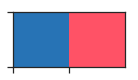

In [100]:
sns.set_style("ticks", {'grid.color': '.1', 'grid.linestyle': '-'})
palette_list = [sns.color_palette(['#2773b5'])[0], sns.color_palette(["#ff5266"])[0]]
#palette_list = [sns.color_palette('muted')[3], sns.color_palette('muted')[0]]
sns.palplot(palette_list)

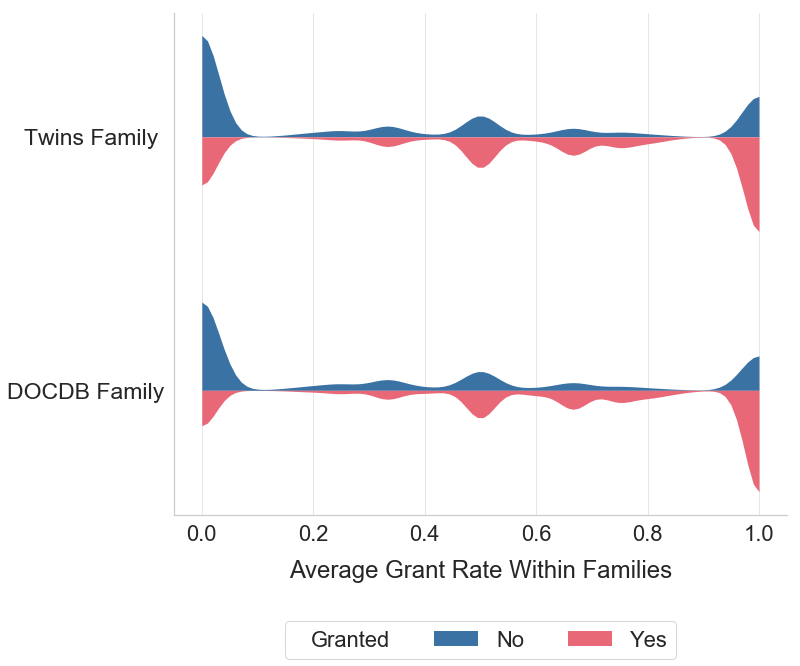

In [103]:
g = sns.catplot(x='avg_grant', y='type', kind="violin", hue='granted', split=True, linewidth=0.0,
                data=df_plot, height=8, aspect=1.4, palette=palette_list, orient='h', bw='scott', cut=0.0)
                #conf_intervals=[(-1, 1)])
g.set_ylabels('', fontsize=20, labelpad=15)
g.set_xlabels('Average Grant Rate Within Families', fontsize=24, labelpad=15)
#g.set(xscale="log")

ytick_label = ['Twins Family ', 'DOCDB Family']

for ax in g.axes.flat:
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(22) 
    #ax.xaxis.set_major_formatter(ticker.PercentFormatter(1))
    ax.set_yticklabels(ytick_label, fontdict={'fontsize':23}, rotation=0)
plt.setp(g._legend.get_texts(), fontsize='22') # for legend text
plt.setp(g._legend.get_title(), fontsize='22') # for legend title

g._legend.remove()
ax = g.axes.flat[0]
# Putting legend title and labels in one line below the plot
h, l = ax.get_legend_handles_labels() 
ph = [ax.plot([],marker="", ls="")[0]] # Canvas
handles = ph + h
labels = ["Granted"] + ['No', 'Yes']
leg = ax.legend(handles, labels, title='', ncol=3, fontsize=22, loc='center', bbox_to_anchor=(0.5, -0.25))
for vpack in leg._legend_handle_box.get_children()[:1]:
    for hpack in vpack.get_children():
        hpack.get_children()[0].set_width(0)

#g._legend.set_title("Granted at USPTO?")
#for t, l in zip(g._legend.texts, ['No', 'Yes']): 
#    t.set_text(l)
#g._legend.set_bbox_to_anchor((1.18,0.55))

#plt.title('My title', fontsize=20)
plt.show()

## 4. Other Patent Authority Offices Relation with USPTO

Here, we want to investigate how much USPTO and other patent offices are acting alike in the case of granting patents to twins.

In [372]:
%%bigquery df_

SELECT
    appln_filing_year_US AS filing_year,
    CAST(granted_US AS INT64) AS granted_us,
    twin_EP, twin_JP, twin_CN, twin_KR, twin_DE, twin_CA, twin_AU, twin_TW
FROM `usptobias.usptobias_dataset.8_final_dataset`
WHERE appln_filing_year_US BETWEEN 2002 AND 2012


In [373]:
df_plot = df_.copy()

df_plot.iloc[:,1:] = df_plot.iloc[:,1:].replace(-1.0, None)
df_plot.granted_us = df_plot.granted_us.astype('float')

print(df_plot.shape)
df_plot.head(3)

(2097799, 10)


,filing_year,granted_us,twin_EP,twin_JP,twin_CN,twin_KR,twin_DE,twin_CA,twin_AU,twin_TW
0,2005,0.0,0.0,0.0,0.0,1.0,NaN,0.0,0.0,NaN
1,2011,0.0,0.0,0.0,1.0,0.0,NaN,1.0,NaN,NaN
2,2010,0.0,0.0,1.0,1.0,1.0,NaN,0.0,1.0,1.0


In [374]:
for column in df_plot.iloc[:,2:]:
    df_plot[column] = (df_plot[column] - df_plot['granted_us']).abs()

df_plot.head(3)

,filing_year,granted_us,twin_EP,twin_JP,twin_CN,twin_KR,twin_DE,twin_CA,twin_AU,twin_TW
0,2005,0.0,0.0,0.0,0.0,1.0,NaN,0.0,0.0,NaN
1,2011,0.0,0.0,0.0,1.0,0.0,NaN,1.0,NaN,NaN
2,2010,0.0,0.0,1.0,1.0,1.0,NaN,0.0,1.0,1.0


In [375]:
df_plot2 = df_plot.drop(columns=['granted_us']).set_index('filing_year').stack().reset_index() \
                  .rename(columns={'level_1':'appln_auth', 0:'dis'})

df_plot2.head(3)

,filing_year,appln_auth,dis
0,2005,twin_EP,0.0
1,2005,twin_JP,0.0
2,2005,twin_CN,0.0


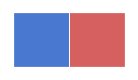

In [376]:
palette_list = [sns.color_palette('muted')[0], sns.color_palette('muted')[3]]
sns.palplot(palette_list)

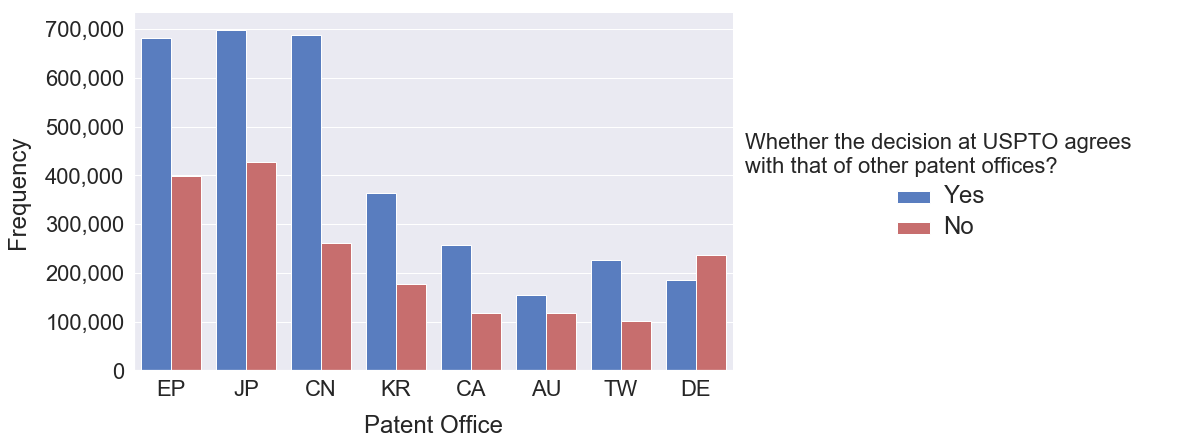

In [388]:
g = sns.catplot(x="appln_auth", hue="dis", palette=palette_list, 
                data=df_plot2, kind="count", height=6, aspect=1.6)


g.set_ylabels('Frequency', fontsize=24, labelpad=15)
g.set_xlabels('Patent Office', fontsize=24, labelpad=15)

auth_list2 = ['EP', 'JP', 'CN', 'KR', 'CA', 'AU', 'TW', 'DE']
for ax in g.axes.flat:
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(22)
    ax.set_xticklabels(auth_list2, fontdict={'fontsize':22}, rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), fontdict={'fontsize':22}, rotation=0)
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.setp(g._legend.get_texts(), fontsize='24') # for legend text
plt.setp(g._legend.get_title(), fontsize='22') # for legend title

g._legend.set_title("Whether the decision at USPTO agrees \nwith that of other patent offices?")
for t, l in zip(g._legend.texts, ['Yes', 'No']): 
    t.set_text(l)
g._legend.set_bbox_to_anchor((1.49,0.6))
    
#ax.set_title('My title', fontsize=20)
plt.show()

# 5. Distibution of Office Actions

We now look into the distribution of the number of office actions for two different cases: inventors is being foreigner or not. We look at 4 types of office actions: "Rejections" (Which counts the total number of non-final and final rejections for each application), "Transactions" (Which is all of the office actions for each applications), "Applicant's Transactions" (which is the office actions that are initiated by applicants, and finally "Examiner's Transactions" (which similarly is the number of office actions initiated by the examiners).

In [104]:
%%bigquery df_

SELECT
    invt_foreign, #granted_US,
    nb_rejection,
    nb_transaction,
    nb_transaction_aa,
    nb_transaction_ex
FROM `usptobias.usptobias_dataset.8_final_dataset`
WHERE appln_filing_year_US BETWEEN 2002 AND 2012

In [105]:
df_plot3 = df_.copy()
print(df_.shape)
df_.head(3)

(2097799, 5)


,invt_foreign,nb_rejection,nb_transaction,nb_transaction_aa,nb_transaction_ex
0,1.0,0.0,20.0,4.0,1.0
1,1.0,6.0,84.0,11.0,37.0
2,1.0,4.0,83.0,12.0,33.0


In [106]:
df_plot = df_plot3.sample(n=1000000, replace=False, random_state=1).sort_values(by=['invt_foreign']).reset_index(drop=True)

df_plot = df_plot.set_index('invt_foreign').stack(level=-1).reset_index()
df_plot = df_plot.rename(columns={'level_1':'type', 0:'num'}).sort_values(by=['invt_foreign', 'type']).reset_index(drop=True)
df_plot = df_plot[df_plot.num<80]
print(df_plot.shape)
df_plot.head(2)

(3510295, 3)


,invt_foreign,type,num
0,0.0,nb_rejection,2.0
1,0.0,nb_rejection,0.0


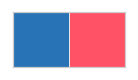

In [107]:
sns.set_style("whitegrid", {'grid.color': '.9', 'grid.linestyle': '-'})
palette_list = [sns.color_palette(['#2773b5'])[0], sns.color_palette(["#ff5266"])[0]]
#palette_list = [sns.color_palette('muted')[3], sns.color_palette('muted')[0]]
sns.palplot(palette_list)

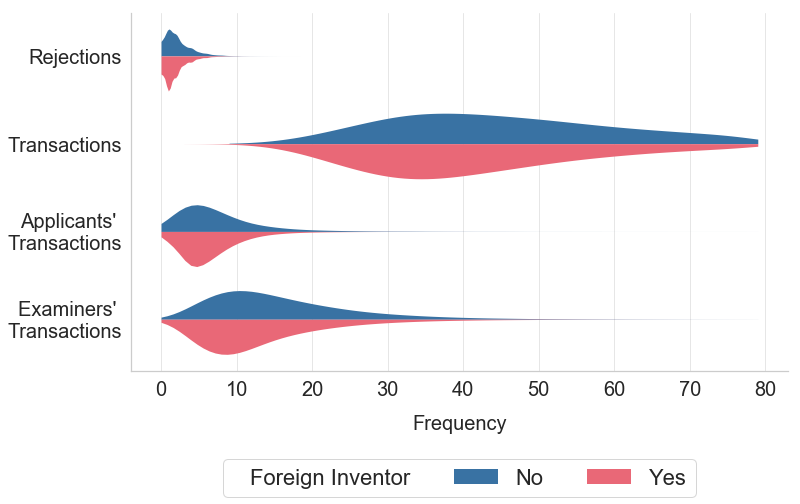

In [108]:
g = sns.catplot(x='num', y='type', kind="violin", hue='invt_foreign', split=True, linewidth=0.0,
                data=df_plot, height=6, aspect=2.0, palette=palette_list, orient='h', bw=0.25, cut=0.0)
                #conf_intervals=[(-1, 1)])
g.set_ylabels('', fontsize=20, labelpad=15)
g.set_xlabels('Frequency', fontsize=20, labelpad=15)
#g.set(xscale="log")

ytick_list = ['Rejections', 'Transactions', 
              "Applicants' \nTransactions", "Examiners' \nTransactions"]
for ax in g.axes.flat:
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20) 
    ax.set_yticklabels(ytick_list, fontdict={'fontsize':20}, rotation=0)
plt.setp(g._legend.get_texts(), fontsize='18') # for legend text
plt.setp(g._legend.get_title(), fontsize='18') # for legend title

g._legend.remove()
ax = g.axes.flat[0]
# Putting legend title and labels in one line below the plot
h, l = ax.get_legend_handles_labels() 
ph = [ax.plot([],marker="", ls="")[0]] # Canvas
handles = ph + h
labels = ["Foreign Inventor"] + ['No', 'Yes']
leg = ax.legend(handles, labels, title='', ncol=3, fontsize=22, loc='center', bbox_to_anchor=(0.5, -0.3))
for vpack in leg._legend_handle_box.get_children()[:1]:
    for hpack in vpack.get_children():
        hpack.get_children()[0].set_width(0)

#g._legend.set_title("Granted at USPTO?")
#for t, l in zip(g._legend.texts, ['No', 'Yes']): 
#    t.set_text(l)
#    t.set_fontsize(18)
#g._legend.set_bbox_to_anchor((0.82,0.88))

#plt.title('My title', fontsize=20)
plt.show()

# 6. Specific Groups

We now look into the missing values and distribution of different variables that are an indicator for the specific group of inventors, including "Muslims", "Chinese", "Japanese", and "Foreign".

In [593]:
%%bigquery df_

SELECT
    granted_US,
    (CASE WHEN (granted_US=1) AND (nb_rejection=0) THEN 1 ELSE 0 END) AS granted_first_action,
    invt_muslim,
    invt_chinese,
    invt_japanese,
    invt_foreign
FROM `usptobias.usptobias_dataset.8_final_dataset`
WHERE appln_filing_year_US BETWEEN 2002 AND 2012

In [532]:
df_plot = df_.copy()
df_plot.head(3)

,granted_US,granted_first_action,invt_muslim,invt_chinese,invt_japanese,invt_foreign
0,0,0,0.0,0.0,0.0,1.0
1,0,0,1.0,0.0,0.0,0.0
2,1,0,0.0,0.0,0.0,1.0


## 6.1. Frequency of each

In [284]:
df_plot = df_plot.fillna(-9999)
df_plot = df_plot.drop(columns=['granted_US', 'granted_first_action']).stack().reset_index(level=-1) \
                  .rename(columns={'level_1':'group', 0:'outcome'})

df_plot.head(3)

,group,outcome
0,invt_muslim,0.0
0,invt_chinese,0.0
0,invt_japanese,0.0


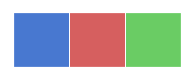

In [288]:
palette_list = [sns.color_palette('muted')[0], sns.color_palette('muted')[3], sns.color_palette('muted')[2]]
sns.palplot(palette_list)

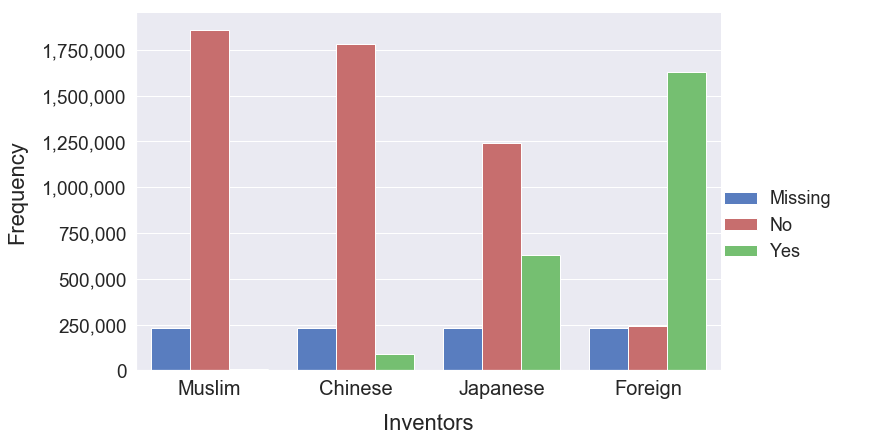

In [292]:
g = sns.catplot(x="group", hue="outcome", palette=palette_list, 
                data=df_plot, kind="count", height=6, aspect=1.6)

g.set_ylabels('Frequency', fontsize=22, labelpad=15)
g.set_xlabels('Inventors', fontsize=22, labelpad=15)

group_list = ['Muslim', 'Chinese', 'Japanese', 'Foreign']
for ax in g.axes.flat:
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    ax.set_xticklabels(group_list, fontdict={'fontsize':20}, rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), fontdict={'fontsize':19}, rotation=0)
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.setp(g._legend.get_texts(), fontsize='18') # for legend text
#plt.setp(g._legend.get_title(), fontsize='18') # for legend title

g._legend.set_title("")
for t, l in zip(g._legend.texts, ["Missing",'No', 'Yes']): 
    t.set_text(l)
g._legend.set_bbox_to_anchor((1.05,0.5))
    
#ax.set_title('My title', fontsize=20)
plt.show()

## 6.2. Logistic Regression Plot for Each Group of Inventors per granted at first Office action

We now look into the relationship between the event of an application being granted a patent in the first office action Vs. inventors being a member of specific groups ("Muslims", "Chinese", "Japanese", and "Foreign).

In [543]:
df_plot = df_.copy()
df_plot.head(3)

,granted_US,granted_first_action,invt_muslim,invt_chinese,invt_japanese,invt_foreign
0,0,0,0.0,0.0,0.0,1.0
1,0,0,1.0,0.0,0.0,0.0
2,1,0,0.0,0.0,0.0,1.0


In [544]:
df_plot = df_plot.sample(n=100000, replace=False, random_state=1).sort_values(by='granted_first_action').reset_index(drop=True)

df_plot = df_plot.drop(columns='granted_US').set_index(['granted_first_action', 'invt_foreign']).stack(level=-1).reset_index()
df_plot = df_plot.rename(columns={'level_2':'type', 0:'outcome'})
print(df_plot.shape)
df_plot.head(2)

(266901, 4)


,granted_first_action,invt_foreign,type,outcome
0,0,1.0,invt_muslim,0.0
1,0,1.0,invt_chinese,1.0


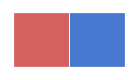

In [545]:
palette_list = [sns.color_palette('muted')[3], sns.color_palette('muted')[0]]
sns.palplot(palette_list)

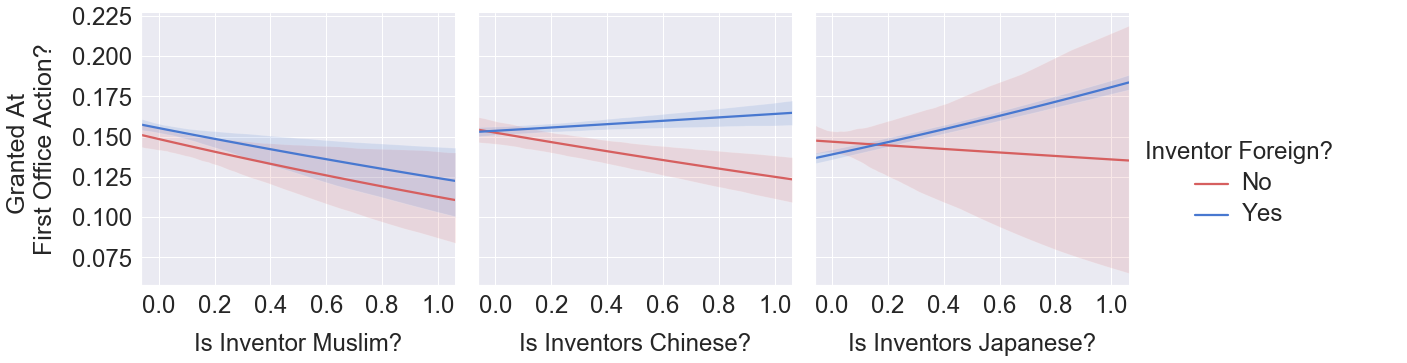

In [548]:
lm = sns.lmplot(x="outcome", y="granted_first_action", hue='invt_foreign', col='type', sharey=True, data=df_plot, ci=95,
                  logistic=True, n_boot=800, y_jitter=.03, scatter=False, palette=palette_list)

label_list = ['Is Inventor Muslim?', 'Is Inventors Chinese?', 'Is Inventors Japanese?']
for i, (ax, label) in enumerate(zip(lm.fig.axes, label_list)):
    ax.set_title("")
    ax.set_xlabel(label, fontsize=24, labelpad=15)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    if i==0:
        ax.set_ylabel("Granted At \nFirst Office Action?", fontsize=25, labelpad=15)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(24)

plt.setp(lm._legend.get_texts(), fontsize='24') # for legend text
plt.setp(lm._legend.get_title(), fontsize='24') # for legend title

lm._legend.set_title("Inventor Foreign?")
for t, l in zip(lm._legend.texts, ['No', 'Yes']): 
    t.set_text(l)
lm._legend.set_bbox_to_anchor((1.15,0.5))
    
#ax.set_title('My title', fontsize=20)
plt.show()

# 7. Psuedo Fixed Effects

We now look into the relationship between an applications being granted a patent Vs. the effect of different pseudo fixed effects that we have included in our final model.

In [118]:
%%bigquery df_

SELECT
    granted_US,
    invt_foreign,
    (CASE WHEN (granted_US=1) AND (nb_rejection=0) THEN 1 ELSE 0 END) AS granted_first_action,
    appln_filing_year_US AS filing_year,
    attorney_FE,
    examiner_FE,
    artunit_FE
FROM `usptobias.usptobias_dataset.8_final_dataset`
WHERE appln_filing_year_US BETWEEN 2002 AND 2012

In [119]:
print(df_.shape)
df_.head(3)

(2097799, 7)


,granted_US,invt_foreign,granted_first_action,filing_year,attorney_FE,examiner_FE,artunit_FE
0,0,1.0,0,2002,0.863410,0.822555,0.826369
1,0,1.0,0,2002,0.841874,0.783315,0.855823
2,0,0.0,0,2002,0.865309,0.814549,0.702299


In [123]:
df_plot = df_.sample(n=1000000, replace=False, random_state=1) \
             .set_index(['granted_US', 'granted_first_action', 'invt_foreign', 'filing_year']) \
             .stack().reset_index().rename(columns={'level_4':'type', 0:'rate'}).copy()

df_plot.head(2)

,granted_US,granted_first_action,invt_foreign,filing_year,type,rate
0,1,0,1.0,2010,attorney_FE,0.822659
1,1,0,1.0,2010,examiner_FE,0.813793


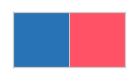

In [124]:
sns.set_style("whitegrid", {'grid.color': '.8', 'grid.linestyle': '-'})
palette_list = [sns.color_palette(['#2773b5'])[0], sns.color_palette(["#ff5266"])[0]]
#palette_list = [sns.color_palette('muted')[3], sns.color_palette('muted')[0]]
sns.palplot(palette_list)

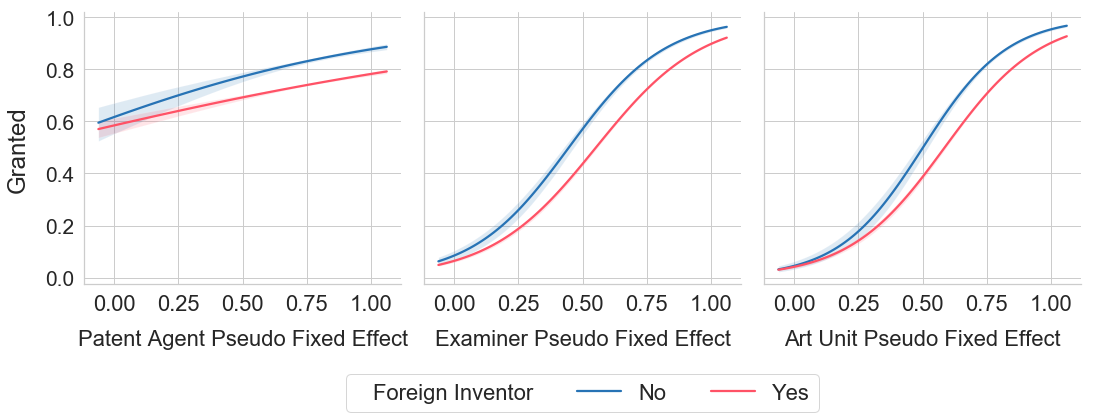

In [122]:
lm = sns.lmplot(x="rate", y="granted_US", hue='invt_foreign', col='type', sharey=True, data=df_plot, ci=95,
                  logistic=True, n_boot=700, y_jitter=.03, scatter=False, palette=palette_list)

label_list = ['Patent Agent Pseudo Fixed Effect', 'Examiner Pseudo Fixed Effect', 'Art Unit Pseudo Fixed Effect']
for i, (ax, label) in enumerate(zip(lm.fig.axes, label_list)):
    ax.set_title("")
    ax.set_xlabel(label, fontsize=22, labelpad=15)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(22)
    if i==0:
        ax.set_ylabel("Granted", fontsize=24, labelpad=15)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(21)

plt.setp(lm._legend.get_texts(), fontsize='22') # for legend text
plt.setp(lm._legend.get_title(), fontsize='22') # for legend title

lm._legend.remove()
ax = lm.axes.flat[1]
# Putting legend title and labels in one line below the plot
h, l = ax.get_legend_handles_labels() 
ph = [ax.plot([],marker="", ls="")[0]] # Canvas
handles = ph + h
labels = ["Foreign Inventor"] + ['No', 'Yes']
leg = ax.legend(handles, labels, title='', ncol=3, fontsize=22, loc='center', bbox_to_anchor=(0.5, -0.4))
for vpack in leg._legend_handle_box.get_children()[:1]:
    for hpack in vpack.get_children():
        hpack.get_children()[0].set_width(0)
        
#lm._legend.set_title("Inventor Foreign?")
#for t, l in zip(lm._legend.texts, ['No', 'Yes']): 
#    t.set_text(l)
#lm._legend.set_bbox_to_anchor((0.5,-0.0))
#ax.set_title('My title', fontsize=20)
plt.show()

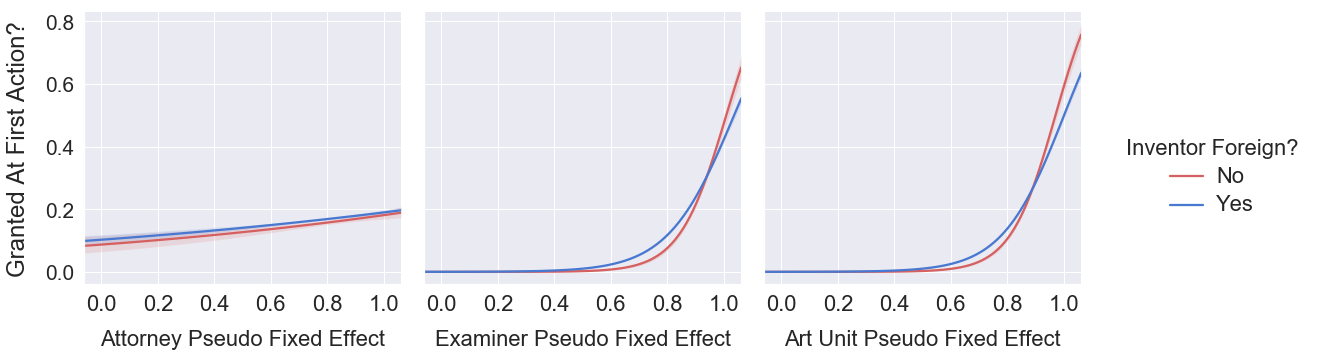

In [471]:
lm = sns.lmplot(x="rate", y="granted_first_action", hue='invt_foreign', col='type', sharey=True, data=df_plot, ci=95,
                  logistic=True, n_boot=500, y_jitter=.03, scatter=False, palette=palette_list)

label_list = ['Attorney Pseudo Fixed Effect', 'Examiner Pseudo Fixed Effect', 'Art Unit Pseudo Fixed Effect']
for i, (ax, label) in enumerate(zip(lm.fig.axes, label_list)):
    ax.set_title("")
    ax.set_xlabel(label, fontsize=22, labelpad=15)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(22)
    if i==0:
        ax.set_ylabel("Granted At First Action?", fontsize=24, labelpad=15)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(21)

plt.setp(lm._legend.get_texts(), fontsize='22') # for legend text
plt.setp(lm._legend.get_title(), fontsize='22') # for legend title

lm._legend.set_title("Inventor Foreign?")
for t, l in zip(lm._legend.texts, ['No', 'Yes']): 
    t.set_text(l)
lm._legend.set_bbox_to_anchor((1.12,0.5))
    
#ax.set_title('My title', fontsize=20)
plt.show()

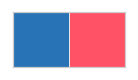

In [26]:
sns.set_style("whitegrid", {'grid.color': '.9', 'grid.linestyle': '-'})
palette_list = [sns.color_palette(['#2773b5'])[0], sns.color_palette(["#ff5266"])[0]]
#palette_list = [sns.color_palette('muted')[3], sns.color_palette('muted')[0]]
sns.palplot(palette_list)

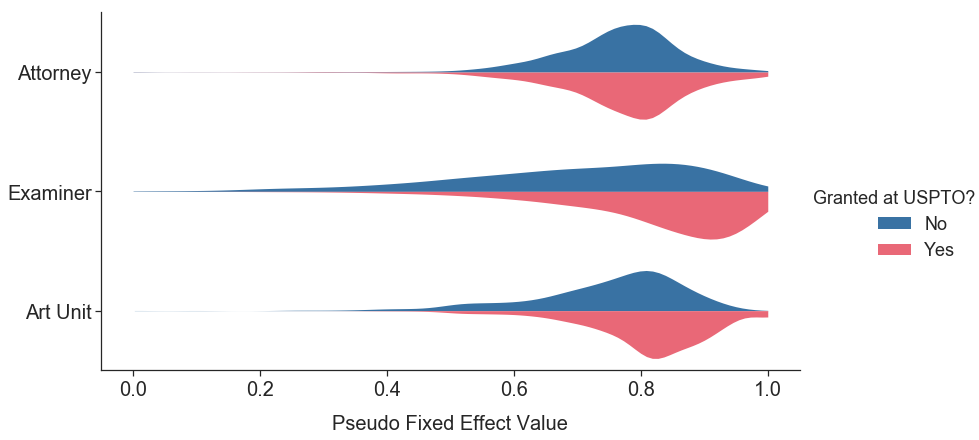

In [24]:
g = sns.catplot(x='rate', y='type', kind="violin", hue='granted_US', split=True, linewidth=0.0,
                data=df_plot, height=6, aspect=2.0, palette=palette_list, orient='h', bw=0.25, cut=0.0)

g.set_ylabels('', fontsize=20, labelpad=15)
g.set_xlabels('Pseudo Fixed Effect Value', fontsize=20, labelpad=15)
#g.set(xscale="log")

ytick_list = ['Attorney', 'Examiner', "Art Unit"]
for ax in g.axes.flat:
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20) 
    ax.set_yticklabels(ytick_list, fontdict={'fontsize':20}, rotation=0)
plt.setp(g._legend.get_texts(), fontsize='18') # for legend text
plt.setp(g._legend.get_title(), fontsize='18') # for legend title

g._legend.set_title("Granted at USPTO?        .")
for t, l in zip(g._legend.texts, ['No', 'Yes']): 
    t.set_text(l)
    t.set_fontsize(18)
g._legend.set_bbox_to_anchor((1.08,0.5))

#plt.title('My title', fontsize=20)
plt.show()

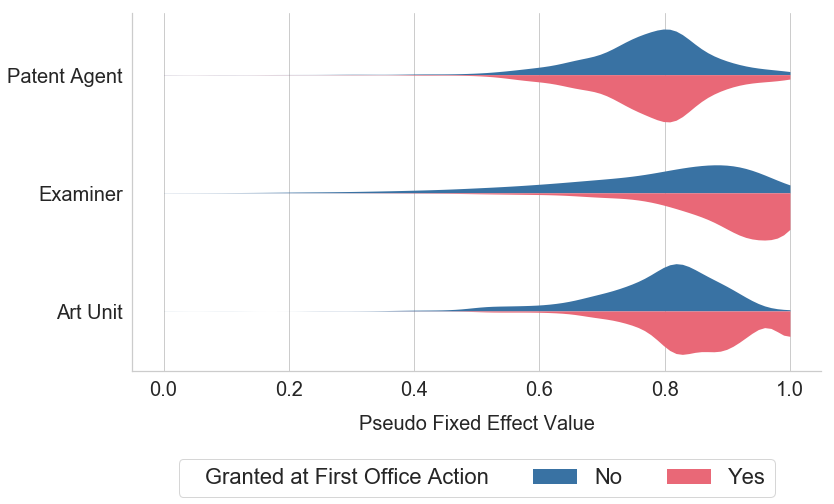

In [125]:
g = sns.catplot(x='rate', y='type', kind="violin", hue='granted_first_action', split=True, linewidth=0.0,
                data=df_plot, height=6, aspect=2.0, palette=palette_list, orient='h', bw=0.25, cut=0.0)

g.set_ylabels('', fontsize=20, labelpad=15)
g.set_xlabels('Pseudo Fixed Effect Value', fontsize=20, labelpad=15)
#g.set(xscale="log")

ytick_list = ['Patent Agent', 'Examiner', "Art Unit"]
for ax in g.axes.flat:
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20) 
    ax.set_yticklabels(ytick_list, fontdict={'fontsize':20}, rotation=0)
plt.setp(g._legend.get_texts(), fontsize='18') # for legend text
plt.setp(g._legend.get_title(), fontsize='18') # for legend title

g._legend.remove()
ax = g.axes.flat[0]
# Putting legend title and labels in one line below the plot
h, l = ax.get_legend_handles_labels() 
ph = [ax.plot([],marker="", ls="")[0]] # Canvas
handles = ph + h
labels = ["Granted at First Office Action"] + ['No', 'Yes']
leg = ax.legend(handles, labels, title='', ncol=3, fontsize=22, loc='center', bbox_to_anchor=(0.5, -0.3))
for vpack in leg._legend_handle_box.get_children()[:1]:
    for hpack in vpack.get_children():
        hpack.get_children()[0].set_width(0)

#g._legend.set_title("Granted at First         .\nOffice Action?")
#for t, l in zip(g._legend.texts, ['No', 'Yes']): 
#    t.set_text(l)
#    t.set_fontsize(18)
#g._legend.set_bbox_to_anchor((1.0,0.5))


#plt.title('My title', fontsize=20)
plt.show()

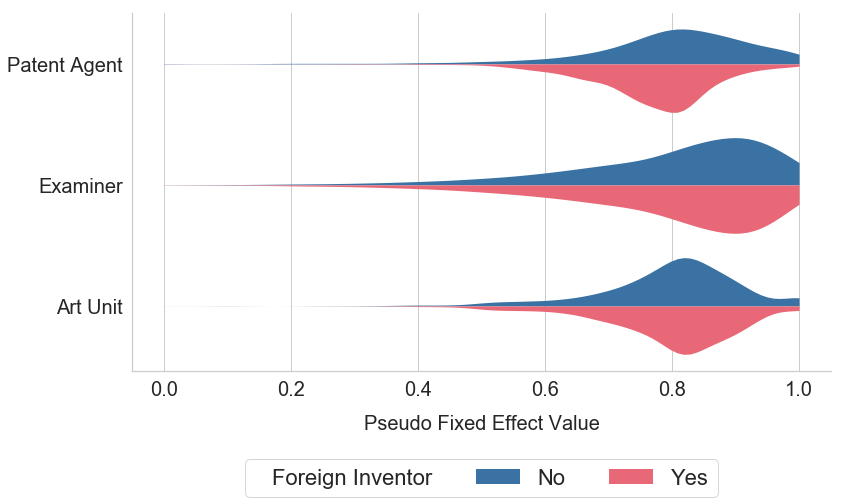

In [126]:
g = sns.catplot(x='rate', y='type', kind="violin", hue='invt_foreign', split=True, linewidth=0.0,
                data=df_plot, height=6, aspect=2.0, palette=palette_list, orient='h', bw=0.25, cut=0.0)

g.set_ylabels('', fontsize=20, labelpad=15)
g.set_xlabels('Pseudo Fixed Effect Value', fontsize=20, labelpad=15)
#g.set(xscale="log")

ytick_list = ['Patent Agent', 'Examiner', "Art Unit"]
for ax in g.axes.flat:
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20) 
    ax.set_yticklabels(ytick_list, fontdict={'fontsize':20}, rotation=0)
plt.setp(g._legend.get_texts(), fontsize='18') # for legend text
plt.setp(g._legend.get_title(), fontsize='18') # for legend title

g._legend.remove()
ax = g.axes.flat[0]
# Putting legend title and labels in one line below the plot
h, l = ax.get_legend_handles_labels() 
ph = [ax.plot([],marker="", ls="")[0]] # Canvas
handles = ph + h
labels = ["Foreign Inventor"] + ['No', 'Yes']
leg = ax.legend(handles, labels, title='', ncol=3, fontsize=22, loc='center', bbox_to_anchor=(0.5, -0.3))
for vpack in leg._legend_handle_box.get_children()[:1]:
    for hpack in vpack.get_children():
        hpack.get_children()[0].set_width(0)

#g._legend.set_title("Inventor Foreign?         .\nOffice Action?")
#for t, l in zip(g._legend.texts, ['No', 'Yes']): 
#    t.set_text(l)
#    t.set_fontsize(18)
#g._legend.set_bbox_to_anchor((1.05,0.5))


#plt.title('My title', fontsize=20)
plt.show()